In [34]:

import sys
from pathlib import Path

p = Path.cwd()
while p != p.parent and not (p / "pyproject.toml").exists():
    p = p.parent

sys.path.insert(0, str(p))
print("Project root:", p)



import pandas as pd
from notebooks.consts import *
from tauso.file_utils import read_human_genome_fasta_dict
from tauso.consts import *
import numpy as np
from tauso.util import get_antisense
import pickle
from tauso.genome.read_human_genome import get_locus_to_data_dict
from tauso.file_utils import read_human_genome_fasta_dict
import RNA
from src.tauso.features.RBP_features import RBP_compatibility
from src.tauso.features.RBP_features import load_rbp_motif_table_rna
from src.tauso.features.RBP_features import get_motifs_by_cellline_rna
from src.tauso.features.RBP_features import add_role_contrast_features

Project root: /home/nivd1/TAUSO


Preprocessing ASO Experimental Dataset

In [35]:
csv_path = NOTEBOOK_PATH / 'data' / 'data_asoptimizer_updated.csv'
all_data = pd.read_csv(str(csv_path), low_memory=False)

In [36]:
from notebooks.notebook_utils import log_correction

# Remove rows with missing values in the INHIBITION column
all_data_no_nan = all_data.dropna(subset=[INHIBITION]).copy()
# Create a new column with transformed inhibition values on a negative log scale
log_correction(all_data_no_nan) # to avoid log 0

In [37]:
# Filter the data to include only rows where the cell line organism is human
all_data_no_nan_human = all_data_no_nan[all_data_no_nan[CELL_LINE_ORGANISM] == 'human']
genes = all_data_no_nan[CANONICAL_GENE].copy()
genes_u = list(set(genes))
# Remove non-human or negative controls from the gene list
genes_u.remove('HBV')
genes_u.remove('negative_control')






In [38]:
from notebooks.notebook_utils import read_cached_gene_to_data

gene_to_data = read_cached_gene_to_data(genes_u)

In [39]:
# Filter data to keep only rows with valid gene information
all_data_human_gene = all_data_no_nan_human[all_data_no_nan_human[CANONICAL_GENE].isin(genes_u)].copy()

# Define names for new columns
SENSE_SEQUENCE = 'sense_sequence'
PRE_MRNA_SEQUENCE = 'pre_mrna_sequence'
SENSE_START = 'sense_start'
SENSE_LENGTH = 'sense_length'

# Initialize new columns
all_data_human_gene[SENSE_SEQUENCE] = ""
all_data_human_gene[PRE_MRNA_SEQUENCE] = ""
all_data_human_gene[SENSE_START] = np.zeros_like(all_data_human_gene[CANONICAL_GENE], dtype=int)
all_data_human_gene[SENSE_LENGTH] = np.zeros_like(all_data_human_gene[CANONICAL_GENE], dtype=int)

# Iterate over each row and compute the antisense complement and the gene's pre-mRNA
for index, row in all_data_human_gene.iterrows():
    gene_name = row[CANONICAL_GENE]

    if gene_name not in gene_to_data:
        continue  # Skip genes not found in genome annotation

    locus_info = gene_to_data[gene_name]
    pre_mrna = locus_info.full_mrna
    antisense = row[SEQUENCE]
    sense = get_antisense(antisense)
    idx = pre_mrna.find(sense)

    # Store computed sequences in new columns
    all_data_human_gene.loc[index, SENSE_START] = idx
    all_data_human_gene.loc[index, SENSE_LENGTH] = len(antisense)
    all_data_human_gene.at[index, SENSE_SEQUENCE] = sense
    all_data_human_gene.at[index, PRE_MRNA_SEQUENCE] = pre_mrna

In [40]:
from src.tauso.genome.read_human_genome import get_locus_to_data_dict

gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=set(genes_u))
g = next(iter(gene_to_data.keys()))
li = gene_to_data[g]

print("Example gene:", g)
print("Type:", type(li))
print("Dir:", [a for a in dir(li) if not a.startswith("_")][:50])

if isinstance(li, dict):
    print("Keys:", li.keys())


Elapsed DB:  0.002358675003051758
Elapsed Fasta:  0.002358675003051758
Length:  3099750718
Feature type:  transcript
Feature type:  transcript
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  start_codon
Feature type:  start_codon
Feature type:  transcript
Feature type:  CDS
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Fe

Get CDS and premRNA windows

In [41]:
new_genes_u = genes_u.copy()
fix_genes = ["KRAS","SOD1","YAP1",'PKK'] 
for fg in fix_genes:
    new_genes_u.append(fg)


In [42]:
from src.tauso.util import get_antisense
from src.tauso.algorithms.genomic_context_windows import add_external_mrna_and_context_columns
df_with_context = add_external_mrna_and_context_columns(df =all_data_no_nan_human, sequence_col=SEQUENCE, canonical_gene_col=CANONICAL_GENE, get_antisense_fn=get_antisense, gene_subset=new_genes_u) 

FLANK_SIZES_CDS = [20, 30, 40, 50, 60, 70]
CDS_WINDOWS = [20, 30, 40, 50, 60, 70]

Elapsed DB:  0.0006735324859619141
Elapsed Fasta:  0.0006735324859619141
Length:  3099750718
Feature type:  transcript
Feature type:  transcript
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  start_codon
Feature type:  start_codon
Feature type:  transcript
Feature type:  CDS
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS


Feature generation

In [43]:
filtered = df_with_context.copy()

In [44]:
from src.tauso.features.RBP_features import RBP_compatibility

# Assumes:
# - `filtered` DataFrame exists
# - columns: "Sequence", "cds_sequence", and f"local_coding_region_around_ASO_{flank}" for each flank in CDS_WINDOWS
# - `RBP_compatibility(aso_seq, target_rna_seq, rbp_motifs)` is the updated, self-contained version we wrote

# Motifs (expanded where needed)
rbp_motifs_raw = [
    # HuR / ELAVL1
    "AUUUA",
    "UUAUUUAUU",
    # TTP / ZFP36
    "UAUUUAU",
    # PTBP1
    "UCUU", "CUCUCU", "UCUUC", "UUCUCU",
    # hnRNP A1
    "UAGGGA", "UAGGGU", "UAGG",
    # MBNL1 (YGCY consensus → commonly UGCU)
    "UGCU",
    # TDP-43 (UG repeats)
    "UG", "UGUG", "UGUGUG",
    # NOVA1/2 (YCAY → expand Y = {C, U})
    # "YCAY" expands to: UCAC, UCAU, CCAC, CCAU
]
rbp_motifs = rbp_motifs_raw + ["UCAC", "UCAU", "CCAC", "CCAU"]

# 1) Per-window RBP compatibility (CAI-style)
RBP_list = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_old_compatibility_{flank}"
    RBP_list.append(out_col)

    filtered[out_col] = filtered.apply(
        lambda row: RBP_compatibility(
            str(row["Sequence"]),
            (str(row[local_col]) if pd.notna(row[local_col]) else ""),
            rbp_motifs
        ),
        axis=1
    )

# 2) Global RBP compatibility on the full CDS (uses cds_sequence)
filtered["RBP_old_global_compatibility"] = filtered.apply(
    lambda row: RBP_compatibility(
        str(row["Sequence"]),
        (str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else ""),
        rbp_motifs
    ),
    axis=1
)



# Keep a handy list of created columns
RBP_list = RBP_list + ["RBP_old_global_compatibility"]


In [ ]:
# Load motifs 
MOTIF_CSV_PATH = "RBP_motifs_for_each_cell_line_with_functional_role_expanded_with_A549.csv"
df_motifs = load_rbp_motif_table_rna(MOTIF_CSV_PATH)

generate the RBP compatibility feature by RBP function

In [ ]:
# ============================================================
# RBP compatibility for DESTABILIZER motifs (RNA mode, clean version)
# ============================================================

from src.tauso.features.RBP_features import get_motifs_by_cellline_rna


# Load motifs and precompute dict: {cell_line: [destabilizer motifs]}

EXPR_THRESHOLD = 3.0

destab_motifs_by_cl = get_motifs_by_cellline_rna(df_motifs,roles=["destabilizer"],expr_threshold=EXPR_THRESHOLD,)

# 1) Per-window compatibility
RBP_destab_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_compatibility_destabilizer_{flank}"
    RBP_destab_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: RBP_compatibility(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            destab_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

# 2) Global compatibility on full CDS
DESTAB_GLOBAL = "RBP_compatibility_destabilizer_global"
filtered[DESTAB_GLOBAL] = filtered.apply(
    lambda row: RBP_compatibility(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        destab_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)


# Handy list of created columns
RBP_destab_features = RBP_destab_cols + [DESTAB_GLOBAL]


In [46]:
# ============================================================
# RBP compatibility for stabilizer motifs 
# ============================================================

from src.tauso.features.RBP_features import get_motifs_by_cellline_rna

# Load motifs and precompute dict: {cell_line: [stabilizer motifs]}
EXPR_THRESHOLD = 3.0

stabilizer_motifs_by_cl = get_motifs_by_cellline_rna(df_motifs,roles=["stabilizer"],expr_threshold=EXPR_THRESHOLD,)

# 1) Per-window compatibility
RBP_stabilizer_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_compatibility_stabilizer_{flank}"
    RBP_stabilizer_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: RBP_compatibility(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            stabilizer_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

# 2) Global compatibility on full CDS
DESTAB_GLOBAL = "RBP_compatibility_stabilizer_global"
filtered[DESTAB_GLOBAL] = filtered.apply(
    lambda row: RBP_compatibility(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        stabilizer_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)


# Handy list of created columns
RBP_stabilizer_features = RBP_stabilizer_cols + [ DESTAB_GLOBAL]

In [47]:
# ============================================================
# RBP compatibility for splicing_regulator motifs 
# ============================================================
from src.tauso.features.RBP_features import get_motifs_by_cellline_rna


# Load motifs and precompute dict: {cell_line: [splicing_regulator motifs]}
EXPR_THRESHOLD = 3.0

splicing_regulator_motifs_by_cl = get_motifs_by_cellline_rna(df_motifs,roles=["splicing_regulator"],expr_threshold=EXPR_THRESHOLD,)

# 1) Per-window compatibility
RBP_splicing_regulator_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_compatibility_splicing_regulator_{flank}"
    RBP_splicing_regulator_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: RBP_compatibility(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            splicing_regulator_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

# 2) Global compatibility on full CDS
DESTAB_GLOBAL = "RBP_compatibility_splicing_regulator_global"
filtered[DESTAB_GLOBAL] = filtered.apply(
    lambda row: RBP_compatibility(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        destab_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)


# Handy list of created columns
RBP_splicing_regulator_features = RBP_splicing_regulator_cols + [DESTAB_GLOBAL]

In [48]:
# ============================================================
# RBP compatibility for translation_regulator motifs 
# ============================================================
from src.tauso.features.RBP_features import get_motifs_by_cellline_rna


# Load motifs and precompute dict: {cell_line: [translation_regulator motifs]}
EXPR_THRESHOLD = 3.0

translation_regulator_motifs_by_cl = get_motifs_by_cellline_rna(df_motifs,roles=["translation_regulator"],expr_threshold=EXPR_THRESHOLD,)

# 1) Per-window compatibility
RBP_translation_regulator_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_compatibility_translation_regulator_{flank}"
    RBP_translation_regulator_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: RBP_compatibility(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            translation_regulator_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

# 2) Global compatibility on full CDS
DESTAB_GLOBAL = "RBP_compatibility_translation_regulator_global"
filtered[DESTAB_GLOBAL] = filtered.apply(
    lambda row: RBP_compatibility(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        translation_regulator_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)



# Handy list of created columns
RBP_translation_regulator_features = RBP_translation_regulator_cols + [DESTAB_GLOBAL]

In [49]:
# ============================================================
# RBP compatibility for other/unclear motifs 
# ============================================================
from src.tauso.features.RBP_features import get_motifs_by_cellline_rna


# Load motifs and precompute dict: {cell_line: [other/unclear motifs]}
EXPR_THRESHOLD = 3.0

other_unclear_motifs_by_cl = get_motifs_by_cellline_rna(df_motifs,roles=["other/unclear"],expr_threshold=EXPR_THRESHOLD,)

# 1) Per-window compatibility
RBP_other_unclear_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_compatibility_other_unclear_{flank}"
    RBP_other_unclear_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: RBP_compatibility(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            other_unclear_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

# 2) Global compatibility on full CDS
DESTAB_GLOBAL = "RBP_compatibility_other_unclear_global"
filtered[DESTAB_GLOBAL] = filtered.apply(
    lambda row: RBP_compatibility(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        other_unclear_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

# Handy list of created columns
RBP_other_unclear_features = RBP_other_unclear_cols + [DESTAB_GLOBAL]

In [50]:
# ============================================================
# RBP compatibility for m6A_reader motifs (RNA mode, clean version)
# ============================================================
from src.tauso.features.RBP_features import get_motifs_by_cellline_rna



EXPR_THRESHOLD = 3.0

m6a_motifs_by_cl = get_motifs_by_cellline_rna(
    df_motifs,
    roles=["m6A_reader"],
    expr_threshold=EXPR_THRESHOLD,
)

# 1) Per-window compatibility
RBP_m6a_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_compatibility_m6A_reader_{flank}"
    RBP_m6a_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: RBP_compatibility(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            m6a_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

# 2) Global compatibility on full CDS
M6A_GLOBAL = "RBP_compatibility_m6A_reader_global"
filtered[M6A_GLOBAL] = filtered.apply(
    lambda row: RBP_compatibility(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        m6a_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)


# Handy list of created columns
RBP_m6a_features = RBP_m6a_cols + [M6A_GLOBAL]


Generate the RBP overlap density features by the RBP function

In [51]:
from src.tauso.features.RBP_features import overlap_density
# ============================================================
# RBP overlap density for DESTABILIZER motifs
# ============================================================

EXPR_THRESHOLD = 3.0

destabilizer_motifs_by_cl = get_motifs_by_cellline_rna(
    df_motifs, roles=["destabilizer"], expr_threshold=EXPR_THRESHOLD
)

RBP_destabilizer_overlap_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_overlap_density_destabilizer_{flank}"
    RBP_destabilizer_overlap_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: overlap_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            destabilizer_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

DESTAB_OVERLAP_GLOBAL = "RBP_overlap_density_destabilizer_global"
filtered[DESTAB_OVERLAP_GLOBAL] = filtered.apply(
    lambda row: overlap_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        destabilizer_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_destabilizer_overlap_features = RBP_destabilizer_overlap_cols + [DESTAB_OVERLAP_GLOBAL]


In [52]:

# ============================================================
# RBP overlap density for stabilizer motifs
# ============================================================

EXPR_THRESHOLD = 3.0

# If not already loaded above:
# df_motifs = load_rbp_motif_table_rna(MOTIF_CSV_PATH)

# Precompute {cell_line: [stabilizer motifs]}
stabilizer_motifs_by_cl = get_motifs_by_cellline_rna(
    df_motifs, roles=["stabilizer"], expr_threshold=EXPR_THRESHOLD
)

# 1) Per-window overlap density
RBP_stabilizer_overlap_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_overlap_density_stabilizer_{flank}"
    RBP_stabilizer_overlap_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: overlap_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            stabilizer_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

# 2) Global (full CDS) overlap density
STAB_OVERLAP_GLOBAL = "RBP_overlap_density_stabilizer_global"
filtered[STAB_OVERLAP_GLOBAL] = filtered.apply(
    lambda row: overlap_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        stabilizer_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)


# Handy list of created columns
RBP_stabilizer_overlap_features = RBP_stabilizer_overlap_cols + [STAB_OVERLAP_GLOBAL]


In [53]:
# ============================================================
# RBP overlap density for SPLICING REGULATOR motifs
# ============================================================

EXPR_THRESHOLD = 3.0

splicing_motifs_by_cl = get_motifs_by_cellline_rna(
    df_motifs, roles=["splicing_regulator"], expr_threshold=EXPR_THRESHOLD
)

RBP_splicing_overlap_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_overlap_density_splicing_regulator_{flank}"
    RBP_splicing_overlap_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: overlap_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            splicing_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

SPLICING_OVERLAP_GLOBAL = "RBP_overlap_density_splicing_regulator_global"
filtered[SPLICING_OVERLAP_GLOBAL] = filtered.apply(
    lambda row: overlap_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        splicing_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_splicing_overlap_features = RBP_splicing_overlap_cols + [SPLICING_OVERLAP_GLOBAL]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/nivd1/miniconda3/envs/aso_design/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3670, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_287348/1248639777.py", line 30, in <module>
    filtered[SPLICING_OVERLAP_GLOBAL] = filtered.apply(
                                        ^^^^^^^^^^^^^^^
  File "/home/nivd1/miniconda3/envs/aso_design/lib/python3.11/site-packages/pandas/core/frame.py", line 10374, in apply
    return op.apply().__finalize__(self, method="apply")
           ^^^^^^^^^^
  File "/home/nivd1/miniconda3/envs/aso_design/lib/python3.11/site-packages/pandas/core/apply.py", line 916, in apply
    return self.apply_standard()
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/nivd1/miniconda3/envs/aso_design/lib/python3.11/site-packages/pandas/core/apply.py", line 1063, in apply_standard
    results, res_index = self.apply_series_generator()
                         ^^^^^^^

In [ ]:
# ============================================================
# RBP overlap density for TRANSLATION REGULATOR motifs
# ============================================================
EXPR_THRESHOLD = 3.0

translation_motifs_by_cl = get_motifs_by_cellline_rna(
    df_motifs, roles=["translation_regulator"], expr_threshold=EXPR_THRESHOLD
)

RBP_translation_overlap_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_overlap_density_translation_regulator_{flank}"
    RBP_translation_overlap_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: overlap_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            translation_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

TRANSLATION_OVERLAP_GLOBAL = "RBP_overlap_density_translation_regulator_global"
filtered[TRANSLATION_OVERLAP_GLOBAL] = filtered.apply(
    lambda row: overlap_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        translation_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_translation_overlap_features = RBP_translation_overlap_cols + [TRANSLATION_OVERLAP_GLOBAL]


In [ ]:
# ============================================================
# RBP overlap density for OTHER/UNCLEAR motifs
# ============================================================
EXPR_THRESHOLD = 3.0

other_motifs_by_cl = get_motifs_by_cellline_rna(
    df_motifs, roles=["other/unclear"], expr_threshold=EXPR_THRESHOLD
)

RBP_other_overlap_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_overlap_density_other_unclear_{flank}"
    RBP_other_overlap_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: overlap_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            other_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

OTHER_OVERLAP_GLOBAL = "RBP_overlap_density_other_unclear_global"
filtered[OTHER_OVERLAP_GLOBAL] = filtered.apply(
    lambda row: overlap_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        other_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_other_overlap_features = RBP_other_overlap_cols + [OTHER_OVERLAP_GLOBAL]


In [ ]:
# ============================================================
# RBP overlap density for m6A_reader motifs
# ============================================================
import pandas as pd

# make sure overlap_density is imported/defined
# from src.tauso.features.RBP_features import overlap_density  # if that's where it lives

EXPR_THRESHOLD = 3.0

m6a_motifs_by_cl = get_motifs_by_cellline_rna(
    df_motifs,
    roles=["m6A_reader"],
    expr_threshold=EXPR_THRESHOLD
)

RBP_m6a_overlap_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_overlap_density_m6A_reader_{flank}"
    RBP_m6a_overlap_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: overlap_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            m6a_motifs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

M6A_OVERLAP_GLOBAL = "RBP_overlap_density_m6A_reader_global"
filtered[M6A_OVERLAP_GLOBAL] = filtered.apply(
    lambda row: overlap_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        m6a_motifs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

# Correct: build the feature list (do NOT use .append() as an expression)
RBP_m6a_overlap_features = RBP_m6a_overlap_cols + [M6A_OVERLAP_GLOBAL]


Role-contrast indices features

In [ ]:
# ============================================================
# Add role-contrast features for selected role pairs
#
# For each pair of roles, we create:
#   • Delta = density(role_a) – density(role_b)
#   • Ratio = density(role_a) / density(role_b)
#
# These features capture the relative balance between different
# categories of RBPs (e.g., destabilizers vs stabilizers).
#
# Notes:
# - Input columns come from overlap density features that were
#   already computed (e.g., RBP_overlap_density_<role>_<flank|global>).
# - Some roles have special characters (e.g., "other/unclear");
#   while they are used in the source column names, the new
#   contrast feature columns replace "/" with "_" for cleaner names.
#
# Example interpretation:
#   • Positive delta: role_a motifs dominate over role_b motifs.
#   • Negative delta: role_b motifs dominate.
#   • High ratio (>1): role_a context is stronger relative to role_b.
# ============================================================
from src.tauso.features.RBP_features import add_role_contrast_features
add_role_contrast_features(filtered, "destabilizer", "stabilizer", CDS_WINDOWS)
add_role_contrast_features(filtered, "splicing_regulator", "translation_regulator", CDS_WINDOWS)
add_role_contrast_features(filtered, "destabilizer", "splicing_regulator", CDS_WINDOWS)
add_role_contrast_features(filtered, "destabilizer", "translation_regulator", CDS_WINDOWS)
add_role_contrast_features(filtered, "other_unclear", "stabilizer", CDS_WINDOWS)
add_role_contrast_features(filtered, "other_unclear", "destabilizer", CDS_WINDOWS)# m6A_reader contrasted against core functional roles
add_role_contrast_features(filtered, "m6A_reader", "stabilizer", CDS_WINDOWS)
add_role_contrast_features(filtered, "m6A_reader", "destabilizer", CDS_WINDOWS)
add_role_contrast_features(filtered, "m6A_reader", "translation_regulator", CDS_WINDOWS)
add_role_contrast_features(filtered, "m6A_reader", "splicing_regulator", CDS_WINDOWS)
add_role_contrast_features(filtered, "m6A_reader", "other_unclear", CDS_WINDOWS)



/home/nivd1/TAUSO/src/tauso/features/RBP_features.py:269: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered[delta_col] = filtered[col_a] - filtered[col_b]
/home/nivd1/TAUSO/src/tauso/features/RBP_features.py:270: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered[ratio_col] = filtered[col_a] / (filtered[col_b] + 1e-6)
/home/nivd1/TAUSO/src/tauso/features/RBP_features.py:269: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

['RBP_overlap_delta_m6A_reader_vs_other_unclear_20',
 'RBP_overlap_ratio_m6A_reader_vs_other_unclear_20',
 'RBP_overlap_delta_m6A_reader_vs_other_unclear_30',
 'RBP_overlap_ratio_m6A_reader_vs_other_unclear_30',
 'RBP_overlap_delta_m6A_reader_vs_other_unclear_40',
 'RBP_overlap_ratio_m6A_reader_vs_other_unclear_40',
 'RBP_overlap_delta_m6A_reader_vs_other_unclear_50',
 'RBP_overlap_ratio_m6A_reader_vs_other_unclear_50',
 'RBP_overlap_delta_m6A_reader_vs_other_unclear_60',
 'RBP_overlap_ratio_m6A_reader_vs_other_unclear_60',
 'RBP_overlap_delta_m6A_reader_vs_other_unclear_70',
 'RBP_overlap_ratio_m6A_reader_vs_other_unclear_70',
 'RBP_overlap_delta_m6A_reader_vs_other_unclear_global',
 'RBP_overlap_ratio_m6A_reader_vs_other_unclear_global']

RBP overlap frac features by RBP functions

In [ ]:
# ============================================================
# Positional splits for DESTABILIZER motifs (left/core/right)
# ============================================================
from src.tauso.features.RBP_features import positional_splits_exact_rna
from src.tauso.features.RBP_features import get_motifs_by_cellline_rna
EXPR_THRESHOLD = 3.0
destabilizer_motifs_by_cl = get_motifs_by_cellline_rna(df_motifs, roles=["destabilizer"], expr_threshold=EXPR_THRESHOLD)

# 1) Per-window
RBP_destab_pos_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_cols  = [
        f"RBP_overlap_frac_destabilizer_left_{flank}",
        f"RBP_overlap_frac_destabilizer_core_{flank}",
        f"RBP_overlap_frac_destabilizer_right_{flank}",
    ]
    RBP_destab_pos_cols += out_cols

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_cols] = filtered.apply(
        lambda row: pd.Series(
            positional_splits_exact_rna(
                str(row["Sequence"]),
                str(row[local_col]) if pd.notna(row[local_col]) else "",
                destabilizer_motifs_by_cl.get(str(row["Cell_line"]), [])
            )
        ),
        axis=1
    )

# 2) Global
DESTAB_POS_GLOBAL = [
    "RBP_overlap_frac_destabilizer_left_global",
    "RBP_overlap_frac_destabilizer_core_global",
    "RBP_overlap_frac_destabilizer_right_global",
]
filtered[DESTAB_POS_GLOBAL] = filtered.apply(
    lambda row: pd.Series(
        positional_splits_exact_rna(
            str(row["Sequence"]),
            str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
            destabilizer_motifs_by_cl.get(str(row["Cell_line"]), [])
        )
    ),
    axis=1
)

RBP_destabilizer_positional_features = RBP_destab_pos_cols + DESTAB_POS_GLOBAL


/tmp/ipykernel_287348/3442632418.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered[out_cols] = filtered.apply(
/tmp/ipykernel_287348/3442632418.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered[out_cols] = filtered.apply(
/tmp/ipykernel_287348/3442632418.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, u

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/nivd1/miniconda3/envs/aso_design/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3670, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_287348/3442632418.py", line 40, in <module>
    filtered[DESTAB_POS_GLOBAL] = filtered.apply(
                                  ^^^^^^^^^^^^^^^
  File "/home/nivd1/miniconda3/envs/aso_design/lib/python3.11/site-packages/pandas/core/frame.py", line 10374, in apply
    return op.apply().__finalize__(self, method="apply")
           ^^^^^^^^^^
  File "/home/nivd1/miniconda3/envs/aso_design/lib/python3.11/site-packages/pandas/core/apply.py", line 916, in apply
    return self.apply_standard()
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/nivd1/miniconda3/envs/aso_design/lib/python3.11/site-packages/pandas/core/apply.py", line 1063, in apply_standard
    results, res_index = self.apply_series_generator()
                         ^^^^^^^^^^^^^^^^^^^

In [ ]:
# ============================================================
# Positional splits for STABILIZER motifs (left/core/right)
# ============================================================

EXPR_THRESHOLD = 3.0
stabilizer_motifs_by_cl = get_motifs_by_cellline_rna(
    df_motifs, roles=["stabilizer"], expr_threshold=EXPR_THRESHOLD
)

RBP_stab_pos_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_cols  = [
        f"RBP_overlap_frac_stabilizer_left_{flank}",
        f"RBP_overlap_frac_stabilizer_core_{flank}",
        f"RBP_overlap_frac_stabilizer_right_{flank}",
    ]
    RBP_stab_pos_cols += out_cols

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_cols] = filtered.apply(
        lambda row: pd.Series(
            positional_splits_exact_rna(
                str(row["Sequence"]),
                str(row[local_col]) if pd.notna(row[local_col]) else "",
                stabilizer_motifs_by_cl.get(str(row["Cell_line"]), [])
            )
        ),
        axis=1
    )

STAB_POS_GLOBAL = [
    "RBP_overlap_frac_stabilizer_left_global",
    "RBP_overlap_frac_stabilizer_core_global",
    "RBP_overlap_frac_stabilizer_right_global",
]
filtered[STAB_POS_GLOBAL] = filtered.apply(
    lambda row: pd.Series(
        positional_splits_exact_rna(
            str(row["Sequence"]),
            str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
            stabilizer_motifs_by_cl.get(str(row["Cell_line"]), [])
        )
    ),
    axis=1
)

RBP_stabilizer_positional_features = RBP_stab_pos_cols + STAB_POS_GLOBAL


In [ ]:
# ============================================================
# Positional splits for SPLICING REGULATOR motifs
# ============================================================

EXPR_THRESHOLD = 3.0
splicing_motifs_by_cl = get_motifs_by_cellline_rna(
    df_motifs, roles=["splicing_regulator"], expr_threshold=EXPR_THRESHOLD
)

RBP_splicing_pos_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_cols  = [
        f"RBP_overlap_frac_splicing_regulator_left_{flank}",
        f"RBP_overlap_frac_splicing_regulator_core_{flank}",
        f"RBP_overlap_frac_splicing_regulator_right_{flank}",
    ]
    RBP_splicing_pos_cols += out_cols

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_cols] = filtered.apply(
        lambda row: pd.Series(
            positional_splits_exact_rna(
                str(row["Sequence"]),
                str(row[local_col]) if pd.notna(row[local_col]) else "",
                splicing_motifs_by_cl.get(str(row["Cell_line"]), [])
            )
        ),
        axis=1
    )

SPLICING_POS_GLOBAL = [
    "RBP_overlap_frac_splicing_regulator_left_global",
    "RBP_overlap_frac_splicing_regulator_core_global",
    "RBP_overlap_frac_splicing_regulator_right_global",
]
filtered[SPLICING_POS_GLOBAL] = filtered.apply(
    lambda row: pd.Series(
        positional_splits_exact_rna(
            str(row["Sequence"]),
            str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
            splicing_motifs_by_cl.get(str(row["Cell_line"]), [])
        )
    ),
    axis=1
)

RBP_splicing_positional_features = RBP_splicing_pos_cols + SPLICING_POS_GLOBAL


In [ ]:
# ============================================================
# Positional splits for TRANSLATION REGULATOR motifs
# ============================================================

EXPR_THRESHOLD = 3.0
translation_motifs_by_cl = get_motifs_by_cellline_rna(
    df_motifs, roles=["translation_regulator"], expr_threshold=EXPR_THRESHOLD
)

RBP_trans_pos_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_cols  = [
        f"RBP_overlap_frac_translation_regulator_left_{flank}",
        f"RBP_overlap_frac_translation_regulator_core_{flank}",
        f"RBP_overlap_frac_translation_regulator_right_{flank}",
    ]
    RBP_trans_pos_cols += out_cols

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_cols] = filtered.apply(
        lambda row: pd.Series(
            positional_splits_exact_rna(
                str(row["Sequence"]),
                str(row[local_col]) if pd.notna(row[local_col]) else "",
                translation_motifs_by_cl.get(str(row["Cell_line"]), [])
            )
        ),
        axis=1
    )

TRANS_POS_GLOBAL = [
    "RBP_overlap_frac_translation_regulator_left_global",
    "RBP_overlap_frac_translation_regulator_core_global",
    "RBP_overlap_frac_translation_regulator_right_global",
]
filtered[TRANS_POS_GLOBAL] = filtered.apply(
    lambda row: pd.Series(
        positional_splits_exact_rna(
            str(row["Sequence"]),
            str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
            translation_motifs_by_cl.get(str(row["Cell_line"]), [])
        )
    ),
    axis=1
)

RBP_translation_positional_features = RBP_trans_pos_cols + TRANS_POS_GLOBAL


In [ ]:
# ============================================================
# Positional splits for OTHER/UNCLEAR motifs
# ============================================================

EXPR_THRESHOLD = 3.0
other_motifs_by_cl = get_motifs_by_cellline_rna(
    df_motifs, roles=["other/unclear"], expr_threshold=EXPR_THRESHOLD
)

RBP_other_pos_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_cols  = [
        f"RBP_overlap_frac_other_unclear_left_{flank}",
        f"RBP_overlap_frac_other_unclear_core_{flank}",
        f"RBP_overlap_frac_other_unclear_right_{flank}",
    ]
    RBP_other_pos_cols += out_cols

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_cols] = filtered.apply(
        lambda row: pd.Series(
            positional_splits_exact_rna(
                str(row["Sequence"]),
                str(row[local_col]) if pd.notna(row[local_col]) else "",
                other_motifs_by_cl.get(str(row["Cell_line"]), [])
            )
        ),
        axis=1
    )

OTHER_POS_GLOBAL = [
    "RBP_overlap_frac_other_unclear_left_global",
    "RBP_overlap_frac_other_unclear_core_global",
    "RBP_overlap_frac_other_unclear_right_global",
]
filtered[OTHER_POS_GLOBAL] = filtered.apply(
    lambda row: pd.Series(
            positional_splits_exact_rna(
                str(row["Sequence"]),
                str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
                other_motifs_by_cl.get(str(row["Cell_line"]), [])
            )
    ),
    axis=1
)

RBP_other_unclear_positional_features = RBP_other_pos_cols + OTHER_POS_GLOBAL


In [ ]:
# ============================================================
# Positional splits for m6A_reader motifs
# ============================================================

import pandas as pd

EXPR_THRESHOLD = 3.0
m6a_motifs_by_cl = get_motifs_by_cellline_rna(
    df_motifs, roles=["m6A_reader"], expr_threshold=EXPR_THRESHOLD
)

RBP_m6a_pos_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_cols  = [
        f"RBP_overlap_frac_m6A_reader_left_{flank}",
        f"RBP_overlap_frac_m6A_reader_core_{flank}",
        f"RBP_overlap_frac_m6A_reader_right_{flank}",
    ]
    RBP_m6a_pos_cols += out_cols

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_cols] = filtered.apply(
        lambda row: pd.Series(
            positional_splits_exact_rna(
                str(row["Sequence"]),
                str(row[local_col]) if pd.notna(row[local_col]) else "",
                m6a_motifs_by_cl.get(str(row["Cell_line"]), [])
            )
        ),
        axis=1
    )

M6A_POS_GLOBAL = [
    "RBP_overlap_frac_m6A_reader_left_global",
    "RBP_overlap_frac_m6A_reader_core_global",
    "RBP_overlap_frac_m6A_reader_right_global",
]
filtered[M6A_POS_GLOBAL] = filtered.apply(
    lambda row: pd.Series(
        positional_splits_exact_rna(
            str(row["Sequence"]),
            str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
            m6a_motifs_by_cl.get(str(row["Cell_line"]), [])
        )
    ),
    axis=1
)

# Correct: add the global column names (not a nested list)
RBP_m6a_positional_features = RBP_m6a_pos_cols + M6A_POS_GLOBAL


 Expression-weighted density features

In [ ]:
# ============================================================
# Expression-weighted density for TRANSLATION REGULATOR motifs
# ============================================================
from src.tauso.features.RBP_features import expression_weighted_density
from src.tauso.features.RBP_features import get_motifs_with_expr_by_cellline_rna
EXPR_THRESHOLD = 3.0

# Build: cell_line -> [(motif, expr), ...]
translation_motifs_with_expr_by_cl = get_motifs_with_expr_by_cellline_rna( df_motifs,roles=["translation_regulator"],expr_threshold=EXPR_THRESHOLD)

# Per-window features
RBP_translation_wdens_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_expr_weighted_density_translation_regulator_{flank}"
    RBP_translation_wdens_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: expression_weighted_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            translation_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

# Global feature
TRANSLATION_WDENS_GLOBAL = "RBP_expr_weighted_density_translation_regulator_global"
filtered[TRANSLATION_WDENS_GLOBAL] = filtered.apply(
    lambda row: expression_weighted_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        translation_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_translation_wdens_features = RBP_translation_wdens_cols + [TRANSLATION_WDENS_GLOBAL]


In [ ]:
# ============================================================
# Expression-weighted density for DESTABILIZER motifs
# ============================================================
EXPR_THRESHOLD = 3.0

destabilizer_motifs_with_expr_by_cl = get_motifs_with_expr_by_cellline_rna(
    df_motifs,
    roles=["destabilizer"],
    expr_threshold=EXPR_THRESHOLD
)

RBP_destabilizer_wdens_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_expr_weighted_density_destabilizer_{flank}"
    RBP_destabilizer_wdens_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: expression_weighted_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            destabilizer_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

DESTABILIZER_WDENS_GLOBAL = "RBP_expr_weighted_density_destabilizer_global"
filtered[DESTABILIZER_WDENS_GLOBAL] = filtered.apply(
    lambda row: expression_weighted_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        destabilizer_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_destabilizer_wdens_features = RBP_destabilizer_wdens_cols + [DESTABILIZER_WDENS_GLOBAL]


In [ ]:
# ============================================================
# Expression-weighted density for STABILIZER motifs
# ============================================================
EXPR_THRESHOLD = 3.0

stabilizer_motifs_with_expr_by_cl = get_motifs_with_expr_by_cellline_rna(
    df_motifs,
    roles=["stabilizer"],
    expr_threshold=EXPR_THRESHOLD
)

RBP_stabilizer_wdens_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_expr_weighted_density_stabilizer_{flank}"
    RBP_stabilizer_wdens_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: expression_weighted_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            stabilizer_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

STABILIZER_WDENS_GLOBAL = "RBP_expr_weighted_density_stabilizer_global"
filtered[STABILIZER_WDENS_GLOBAL] = filtered.apply(
    lambda row: expression_weighted_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        stabilizer_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_stabilizer_wdens_features = RBP_stabilizer_wdens_cols + [STABILIZER_WDENS_GLOBAL]


In [ ]:
# ============================================================
# Expression-weighted density for SPLICING REGULATOR motifs
# ============================================================
EXPR_THRESHOLD = 3.0

splicing_motifs_with_expr_by_cl = get_motifs_with_expr_by_cellline_rna(
    df_motifs,
    roles=["splicing_regulator"],
    expr_threshold=EXPR_THRESHOLD
)

RBP_splicing_wdens_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_expr_weighted_density_splicing_regulator_{flank}"
    RBP_splicing_wdens_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: expression_weighted_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            splicing_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

SPLICING_WDENS_GLOBAL = "RBP_expr_weighted_density_splicing_regulator_global"
filtered[SPLICING_WDENS_GLOBAL] = filtered.apply(
    lambda row: expression_weighted_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        splicing_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_splicing_wdens_features = RBP_splicing_wdens_cols + [SPLICING_WDENS_GLOBAL]


In [ ]:
# ============================================================
# Expression-weighted density for OTHER / UNCLEAR motifs
# ============================================================
EXPR_THRESHOLD = 3.0

other_motifs_with_expr_by_cl = get_motifs_with_expr_by_cellline_rna(
    df_motifs,
    roles=["other/unclear"],
    expr_threshold=EXPR_THRESHOLD
)

RBP_other_wdens_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_expr_weighted_density_other_unclear_{flank}"
    RBP_other_wdens_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: expression_weighted_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            other_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

OTHER_WDENS_GLOBAL = "RBP_expr_weighted_density_other_unclear_global"
filtered[OTHER_WDENS_GLOBAL] = filtered.apply(
    lambda row: expression_weighted_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        other_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_other_wdens_features = RBP_other_wdens_cols + [OTHER_WDENS_GLOBAL]


In [ ]:
# ============================================================
# Expression-weighted density for m6A_reader motifs
# ============================================================
import pandas as pd

EXPR_THRESHOLD = 3.0

m6a_motifs_with_expr_by_cl = get_motifs_with_expr_by_cellline_rna(
    df_motifs,
    roles=["m6A_reader"],
    expr_threshold=EXPR_THRESHOLD
)

RBP_m6a_wdens_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_expr_weighted_density_m6A_reader_{flank}"
    RBP_m6a_wdens_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: expression_weighted_density(
            str(row["Sequence"]),
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            m6a_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

M6A_WDENS_GLOBAL = "RBP_expr_weighted_density_m6A_reader_global"
filtered[M6A_WDENS_GLOBAL] = filtered.apply(
    lambda row: expression_weighted_density(
        str(row["Sequence"]),
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        m6a_motifs_with_expr_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_m6a_wdens_features = RBP_m6a_wdens_cols + [M6A_WDENS_GLOBAL]


motif diversity features

In [ ]:
# ============================================================
# Motif diversity (Gene_name-based) for DESTABILIZER
# ============================================================
EXPR_THRESHOLD = 3.0
from src.tauso.features.RBP_features import motif_diversity_window_ratio
from src.tauso.features.RBP_features import get_motif_identity_pairs_by_cellline

destabilizer_pairs_by_cl = get_motif_identity_pairs_by_cellline(
    df_motifs, role="destabilizer", expr_threshold=EXPR_THRESHOLD, identity_col="Gene_name"
)

RBP_destabilizer_diversity_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_motif_diversity_destabilizer_{flank}"
    RBP_destabilizer_diversity_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: motif_diversity_window_ratio(
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            destabilizer_pairs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

DESTABILIZER_DIV_GLOBAL = "RBP_motif_diversity_destabilizer_global"
filtered[DESTABILIZER_DIV_GLOBAL] = filtered.apply(
    lambda row: motif_diversity_window_ratio(
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        destabilizer_pairs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_destabilizer_diversity_features = RBP_destabilizer_diversity_cols + [DESTABILIZER_DIV_GLOBAL]


In [ ]:
# ============================================================
# Motif diversity (Gene_name-based) for STABILIZER
# ============================================================
EXPR_THRESHOLD = 3.0

stabilizer_pairs_by_cl = get_motif_identity_pairs_by_cellline(
    df_motifs, role="stabilizer", expr_threshold=EXPR_THRESHOLD, identity_col="Gene_name"
)

RBP_stabilizer_diversity_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_motif_diversity_stabilizer_{flank}"
    RBP_stabilizer_diversity_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: motif_diversity_window_ratio(
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            stabilizer_pairs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

STABILIZER_DIV_GLOBAL = "RBP_motif_diversity_stabilizer_global"
filtered[STABILIZER_DIV_GLOBAL] = filtered.apply(
    lambda row: motif_diversity_window_ratio(
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        stabilizer_pairs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_stabilizer_diversity_features = RBP_stabilizer_diversity_cols + [STABILIZER_DIV_GLOBAL]


In [ ]:
# ============================================================
# Motif diversity (Gene_name-based) for SPLICING REGULATOR
# ============================================================
EXPR_THRESHOLD = 3.0

splicing_pairs_by_cl = get_motif_identity_pairs_by_cellline(
    df_motifs, role="splicing_regulator", expr_threshold=EXPR_THRESHOLD, identity_col="Gene_name"
)

RBP_splicing_diversity_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_motif_diversity_splicing_regulator_{flank}"
    RBP_splicing_diversity_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: motif_diversity_window_ratio(
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            splicing_pairs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

SPLICING_DIV_GLOBAL = "RBP_motif_diversity_splicing_regulator_global"
filtered[SPLICING_DIV_GLOBAL] = filtered.apply(
    lambda row: motif_diversity_window_ratio(
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        splicing_pairs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_splicing_diversity_features = RBP_splicing_diversity_cols + [SPLICING_DIV_GLOBAL]


In [ ]:
# ============================================================
# Motif diversity (Gene_name-based) for TRANSLATION REGULATOR
# ============================================================
EXPR_THRESHOLD = 3.0

translation_pairs_by_cl = get_motif_identity_pairs_by_cellline(
    df_motifs, role="translation_regulator", expr_threshold=EXPR_THRESHOLD, identity_col="Gene_name"
)

RBP_translation_diversity_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_motif_diversity_translation_regulator_{flank}"
    RBP_translation_diversity_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: motif_diversity_window_ratio(
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            translation_pairs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

TRANSLATION_DIV_GLOBAL = "RBP_motif_diversity_translation_regulator_global"
filtered[TRANSLATION_DIV_GLOBAL] = filtered.apply(
    lambda row: motif_diversity_window_ratio(
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        translation_pairs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_translation_diversity_features = RBP_translation_diversity_cols + [TRANSLATION_DIV_GLOBAL]


In [ ]:
# ============================================================
# Motif diversity (Gene_name-based) for OTHER / UNCLEAR
# ============================================================
EXPR_THRESHOLD = 3.0

other_pairs_by_cl = get_motif_identity_pairs_by_cellline(
    df_motifs, role="other/unclear", expr_threshold=EXPR_THRESHOLD, identity_col="Gene_name"
)

RBP_other_diversity_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_motif_diversity_other_unclear_{flank}"
    RBP_other_diversity_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: motif_diversity_window_ratio(
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            other_pairs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

OTHER_DIV_GLOBAL = "RBP_motif_diversity_other_unclear_global"
filtered[OTHER_DIV_GLOBAL] = filtered.apply(
    lambda row: motif_diversity_window_ratio(
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        other_pairs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_other_diversity_features = RBP_other_diversity_cols + [OTHER_DIV_GLOBAL]


In [ ]:
# ============================================================
# Motif diversity (Gene_name-based) for m6A_reader
# ============================================================
import pandas as pd

EXPR_THRESHOLD = 3.0

m6a_pairs_by_cl = get_motif_identity_pairs_by_cellline(
    df_motifs,
    role="m6A_reader",
    expr_threshold=EXPR_THRESHOLD,
    identity_col="Gene_name"
)

RBP_m6a_diversity_cols = []
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_motif_diversity_m6A_reader_{flank}"
    RBP_m6a_diversity_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: motif_diversity_window_ratio(
            str(row[local_col]) if pd.notna(row[local_col]) else "",
            m6a_pairs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

M6A_DIV_GLOBAL = "RBP_motif_diversity_m6A_reader_global"
filtered[M6A_DIV_GLOBAL] = filtered.apply(
    lambda row: motif_diversity_window_ratio(
        str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        m6a_pairs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_m6a_diversity_features = RBP_m6a_diversity_cols + [M6A_DIV_GLOBAL]


Dominant RBP identity fraction over the ASO binding site features

In [ ]:
# ============================================================
# Dominant RBP identity fraction for SPLICING REGULATOR motifs
# ============================================================
EXPR_THRESHOLD = 3.0

splicing_pairs_by_cl = get_motif_identity_pairs_by_cellline(
    df_motifs,
    role="splicing_regulator",
    expr_threshold=EXPR_THRESHOLD,
    identity_col="Gene_name"
)
RBP_splicing_dominant_cols = []

for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_dominant_fraction_splicing_regulator_{flank}"
    RBP_splicing_dominant_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: dominant_rbp_fraction(
            aso_seq=str(row["Sequence"]),
            target_seq=str(row[local_col]) if pd.notna(row[local_col]) else "",
            motif_identity_pairs=splicing_pairs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

SPLICING_DOMINANT_GLOBAL = "RBP_dominant_fraction_splicing_regulator_global"
filtered[SPLICING_DOMINANT_GLOBAL] = filtered.apply(
    lambda row: dominant_rbp_fraction(
        aso_seq=str(row["Sequence"]),
        target_seq=str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        motif_identity_pairs=splicing_pairs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_splicing_dominant_features = RBP_splicing_dominant_cols + [SPLICING_DOMINANT_GLOBAL]


In [ ]:
# ============================================================
# Dominant RBP identity fraction for STABILIZER motifs
# ============================================================
EXPR_THRESHOLD = 3.0
stabilizer_pairs_by_cl = get_motif_identity_pairs_by_cellline(
    df_motifs,
    role="stabilizer",
    expr_threshold=EXPR_THRESHOLD,
    identity_col="Gene_name"
)

RBP_stabilizer_dominant_cols = []

for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_dominant_fraction_stabilizer_{flank}"
    RBP_stabilizer_dominant_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: dominant_rbp_fraction(
            aso_seq=str(row["Sequence"]),
            target_seq=str(row[local_col]) if pd.notna(row[local_col]) else "",
            motif_identity_pairs=stabilizer_pairs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

STABILIZER_DOMINANT_GLOBAL = "RBP_dominant_fraction_stabilizer_global"
filtered[STABILIZER_DOMINANT_GLOBAL] = filtered.apply(
    lambda row: dominant_rbp_fraction(
        aso_seq=str(row["Sequence"]),
        target_seq=str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        motif_identity_pairs=stabilizer_pairs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_stabilizer_dominant_features = RBP_stabilizer_dominant_cols + [STABILIZER_DOMINANT_GLOBAL]


In [ ]:
# ============================================================
# Dominant RBP identity fraction for DESTABILIZER motifs
# ============================================================

destabilizer_pairs_by_cl = get_motif_identity_pairs_by_cellline(
    df_motifs,
    role="destabilizer",
    expr_threshold=EXPR_THRESHOLD,
    identity_col="Gene_name"
)

RBP_destabilizer_dominant_cols = []

for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_dominant_fraction_destabilizer_{flank}"
    RBP_destabilizer_dominant_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: dominant_rbp_fraction(
            aso_seq=str(row["Sequence"]),
            target_seq=str(row[local_col]) if pd.notna(row[local_col]) else "",
            motif_identity_pairs=destabilizer_pairs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

DESTABILIZER_DOMINANT_GLOBAL = "RBP_dominant_fraction_destabilizer_global"
filtered[DESTABILIZER_DOMINANT_GLOBAL] = filtered.apply(
    lambda row: dominant_rbp_fraction(
        aso_seq=str(row["Sequence"]),
        target_seq=str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        motif_identity_pairs=destabilizer_pairs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_destabilizer_dominant_features = RBP_destabilizer_dominant_cols + [DESTABILIZER_DOMINANT_GLOBAL]


In [ ]:
# ============================================================
# Dominant RBP identity fraction for TRANSLATION REGULATOR motifs
# ============================================================

translation_pairs_by_cl = get_motif_identity_pairs_by_cellline(
    df_motifs,
    role="translation_regulator",
    expr_threshold=EXPR_THRESHOLD,
    identity_col="Gene_name"
)

RBP_translation_dominant_cols = []

for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_dominant_fraction_translation_regulator_{flank}"
    RBP_translation_dominant_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: dominant_rbp_fraction(
            aso_seq=str(row["Sequence"]),
            target_seq=str(row[local_col]) if pd.notna(row[local_col]) else "",
            motif_identity_pairs=translation_pairs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

TRANSLATION_DOMINANT_GLOBAL = "RBP_dominant_fraction_translation_regulator_global"
filtered[TRANSLATION_DOMINANT_GLOBAL] = filtered.apply(
    lambda row: dominant_rbp_fraction(
        aso_seq=str(row["Sequence"]),
        target_seq=str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        motif_identity_pairs=translation_pairs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_translation_dominant_features = RBP_translation_dominant_cols + [TRANSLATION_DOMINANT_GLOBAL]


In [ ]:
# ============================================================
# Dominant RBP identity fraction for m6A_reader motifs
# ============================================================

m6A_reader_pairs_by_cl = get_motif_identity_pairs_by_cellline(
    df_motifs,
    role="m6A_reader",
    expr_threshold=EXPR_THRESHOLD,
    identity_col="Gene_name"
)

RBP_m6A_reader_dominant_cols = []

for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_dominant_fraction_m6A_reader_{flank}"
    RBP_m6A_reader_dominant_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: dominant_rbp_fraction(
            aso_seq=str(row["Sequence"]),
            target_seq=str(row[local_col]) if pd.notna(row[local_col]) else "",
            motif_identity_pairs=m6A_reader_pairs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

M6A_READER_DOMINANT_GLOBAL = "RBP_dominant_fraction_m6A_reader_global"
filtered[M6A_READER_DOMINANT_GLOBAL] = filtered.apply(
    lambda row: dominant_rbp_fraction(
        aso_seq=str(row["Sequence"]),
        target_seq=str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        motif_identity_pairs=m6A_reader_pairs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_m6A_reader_dominant_features = RBP_m6A_reader_dominant_cols + [M6A_READER_DOMINANT_GLOBAL]


In [ ]:
# ============================================================
# Dominant RBP identity fraction for OTHER/UNCLEAR motifs
# ============================================================

other_unclear_pairs_by_cl = get_motif_identity_pairs_by_cellline(
    df_motifs,
    role="other/unclear",
    expr_threshold=EXPR_THRESHOLD,
    identity_col="Gene_name"
)

RBP_other_unclear_dominant_cols = []

for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    out_col   = f"RBP_dominant_fraction_other_unclear_{flank}"
    RBP_other_unclear_dominant_cols.append(out_col)

    if local_col not in filtered.columns:
        filtered[local_col] = ""

    filtered[out_col] = filtered.apply(
        lambda row: dominant_rbp_fraction(
            aso_seq=str(row["Sequence"]),
            target_seq=str(row[local_col]) if pd.notna(row[local_col]) else "",
            motif_identity_pairs=other_unclear_pairs_by_cl.get(str(row["Cell_line"]), [])
        ),
        axis=1
    )

OTHER_UNCLEAR_DOMINANT_GLOBAL = "RBP_dominant_fraction_other_unclear_global"
filtered[OTHER_UNCLEAR_DOMINANT_GLOBAL] = filtered.apply(
    lambda row: dominant_rbp_fraction(
        aso_seq=str(row["Sequence"]),
        target_seq=str(row["cds_sequence"]) if pd.notna(row["cds_sequence"]) else "",
        motif_identity_pairs=other_unclear_pairs_by_cl.get(str(row["Cell_line"]), [])
    ),
    axis=1
)

RBP_other_unclear_dominant_features = RBP_other_unclear_dominant_cols + [OTHER_UNCLEAR_DOMINANT_GLOBAL]


Remove the sequence columns

 Save each feature as CSV in the features directory

In [ ]:
"""""
from scripts.features.feature_extraction import save_feature
feature_list =CAI_list
for feat in feature_list:
    save_feature(filtered, feat)
"""


'""\nfrom scripts.features.feature_extraction import save_feature\nfeature_list =CAI_list\nfor feat in feature_list:\n    save_feature(filtered, feat)\n'

 Save DataFrame as CSV in the current working directory

In [ ]:

#new_filtered.to_csv("features_output_final_update_CUB_final2.csv", index=False)

test the features

In [ ]:
from notebooks.features.RNaseH.correlation_test import analyze_feature_correlations
results_df = analyze_feature_correlations(filtered, target='log_inhibition')
display(results_df)


/home/nivd1/miniconda3/envs/aso_design/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4623: RuntimeWarning: invalid value encountered in subtract
  xm = x - xmean


,Feature,Pearson,Spearman,NMI_max
14,Inhibition(%),0.880,1.000,2.450
1,ISIS,-0.051,-0.129,0.182
24,sense_start,-0.027,0.199,0.129
19,Location_in_sequence,-0.022,0.204,0.129
0,index,0.337,0.325,0.114
...,...,...,...,...
36,local_coding_region_around_ASO_40,NaN,NaN,NaN
37,local_coding_region_around_ASO_50,NaN,NaN,NaN
38,local_coding_region_around_ASO_60,NaN,NaN,NaN
39,local_coding_region_around_ASO_70,NaN,NaN,NaN


Compatibility features

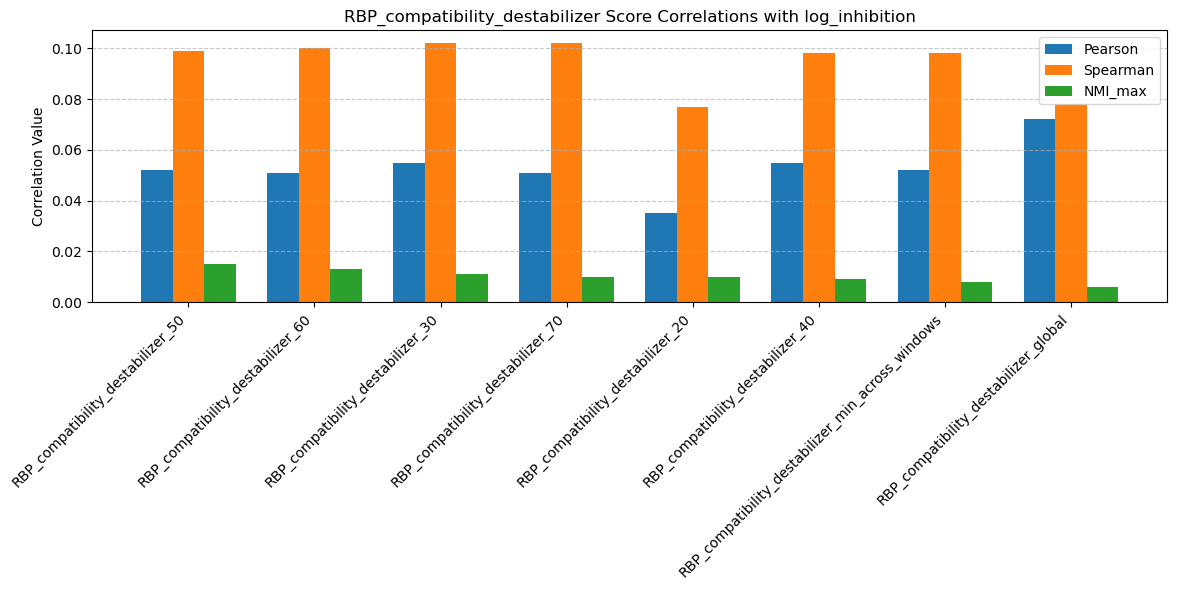

In [ ]:
from notebooks.features.RNaseH.correlation_test import plot_feature_correlations_by_prefix
plot_feature_correlations_by_prefix(results_df, prefix='RBP_compatibility_destabilizer', title='RBP_compatibility_destabilizer Score Correlations with log_inhibition')

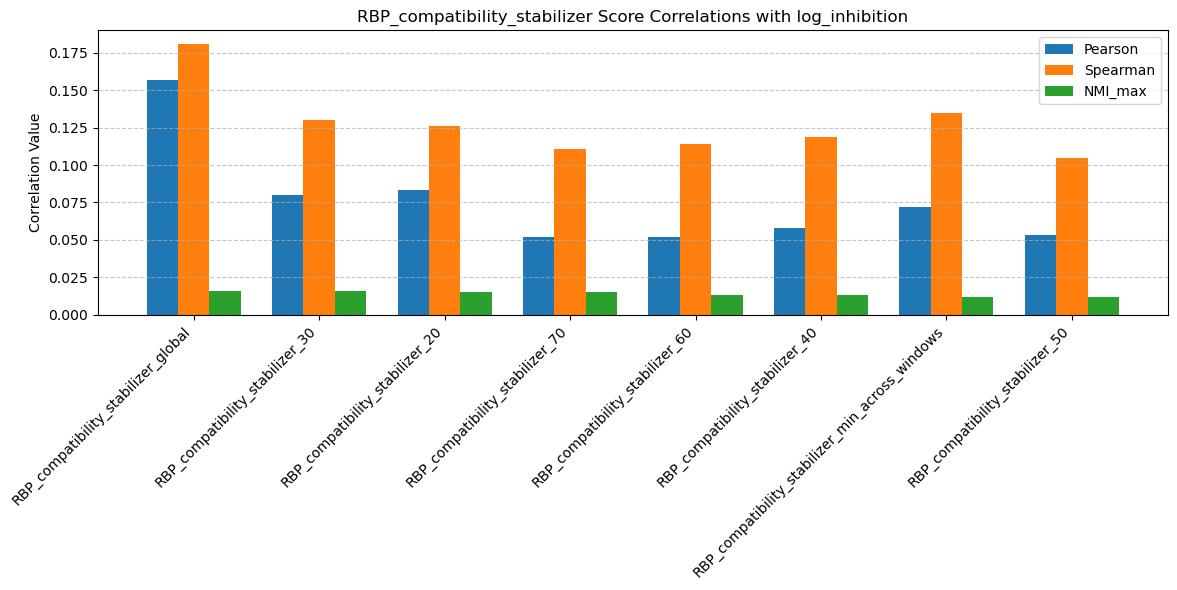

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_compatibility_stabilizer', title='RBP_compatibility_stabilizer Score Correlations with log_inhibition')


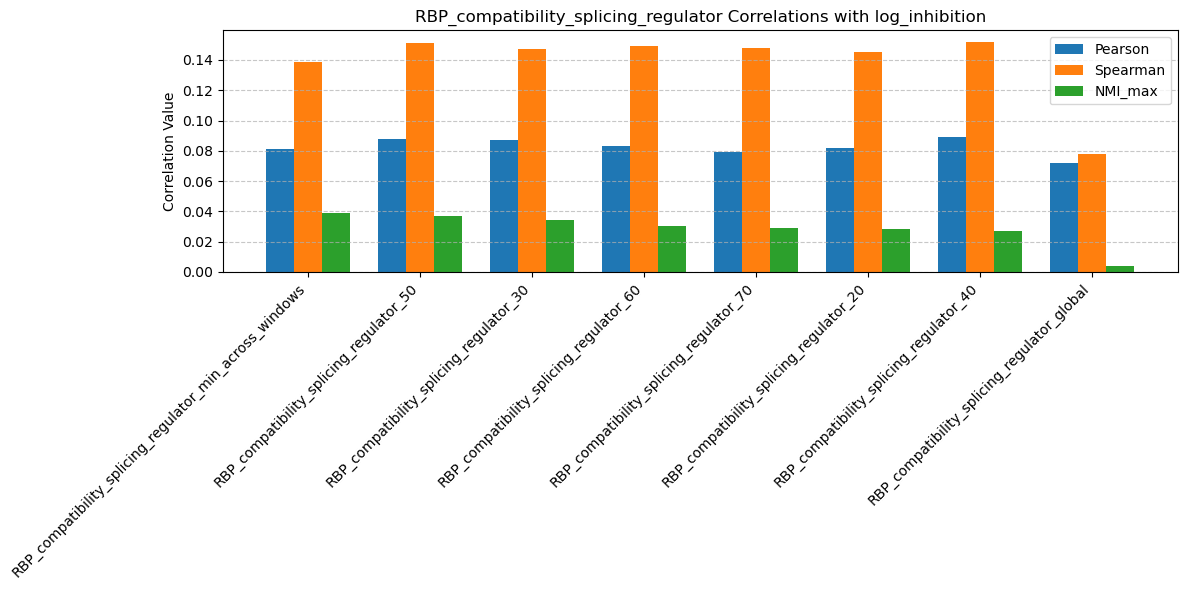

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_compatibility_splicing_regulator', title='RBP_compatibility_splicing_regulator Correlations with log_inhibition')

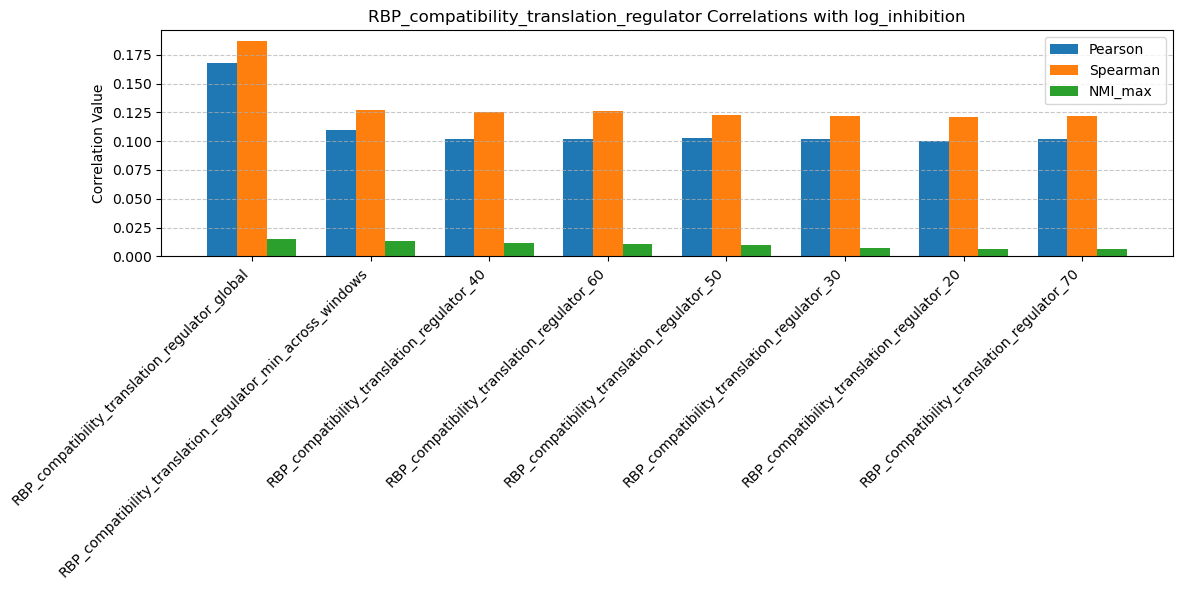

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_compatibility_translation_regulator', title='RBP_compatibility_translation_regulator Correlations with log_inhibition')





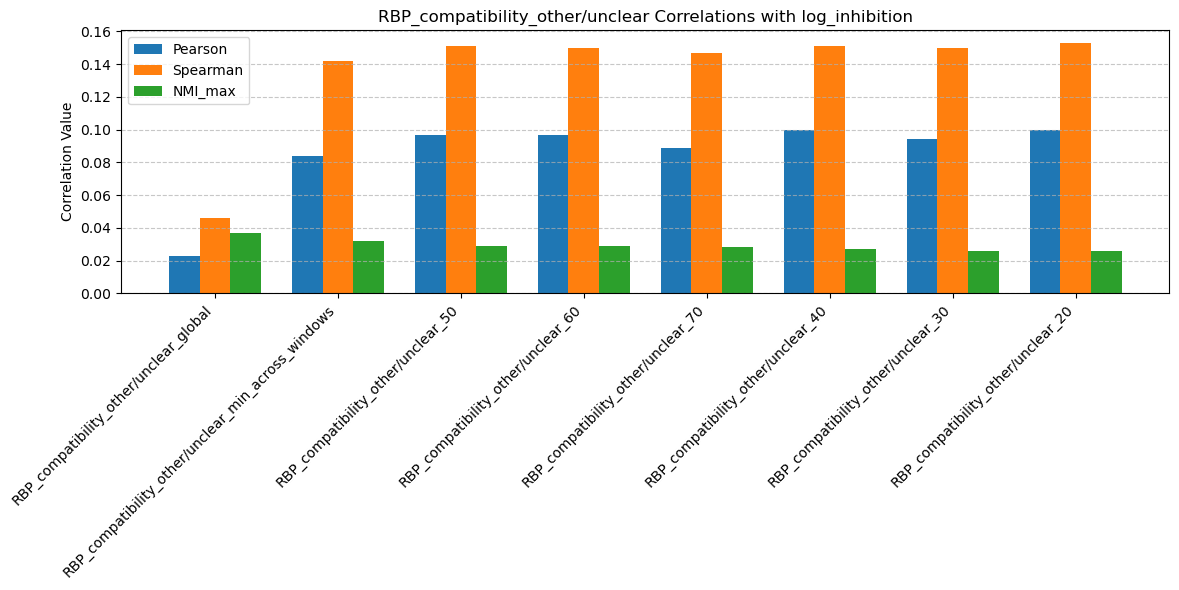

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_compatibility_other_unclear', title='RBP_compatibility_other_unclear Correlations with log_inhibition')

In [ ]:
from notebooks.features.RNaseH.correlation_test import plot_feature_correlations_by_prefix
plot_feature_correlations_by_prefix(results_df, prefix='RBP_compatibility_m6A', title='RBP_compatibility_m6A_reader Score Correlations with log_inhibition')

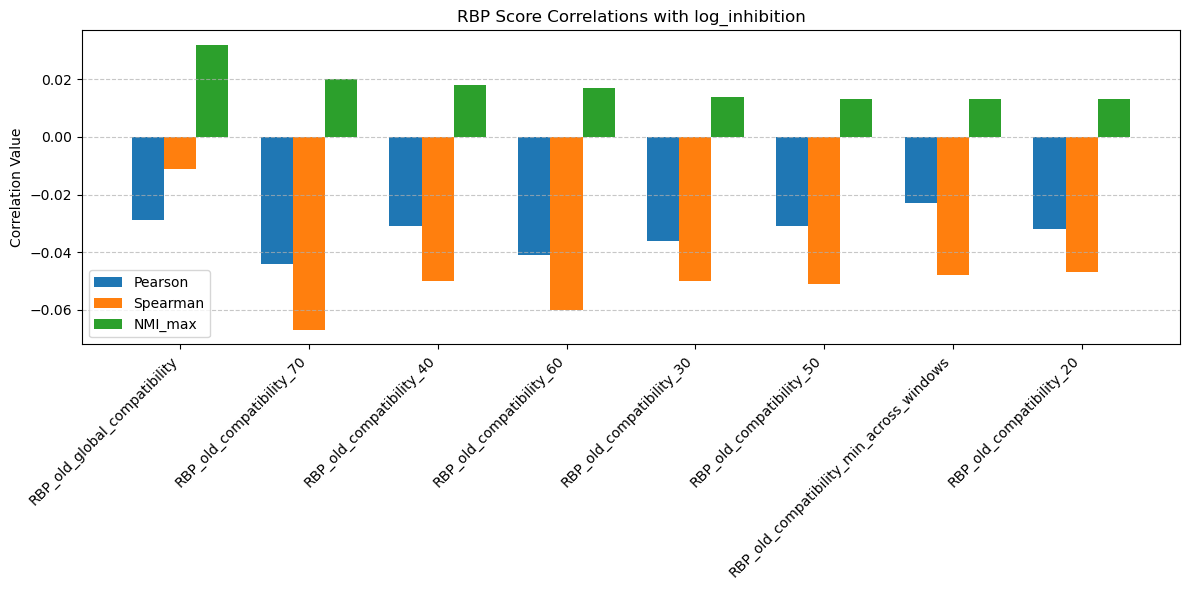

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_old', title='RBP Score Correlations with log_inhibition')


overlap_density features

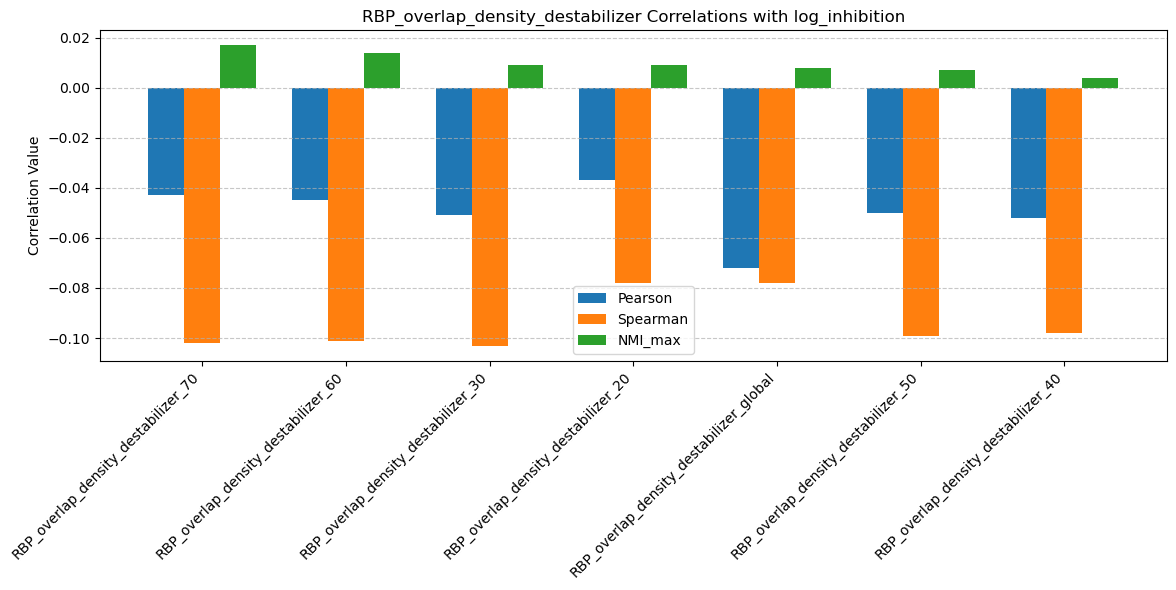

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_density_destabilizer', title='RBP_overlap_density_destabilizer Correlations with log_inhibition')



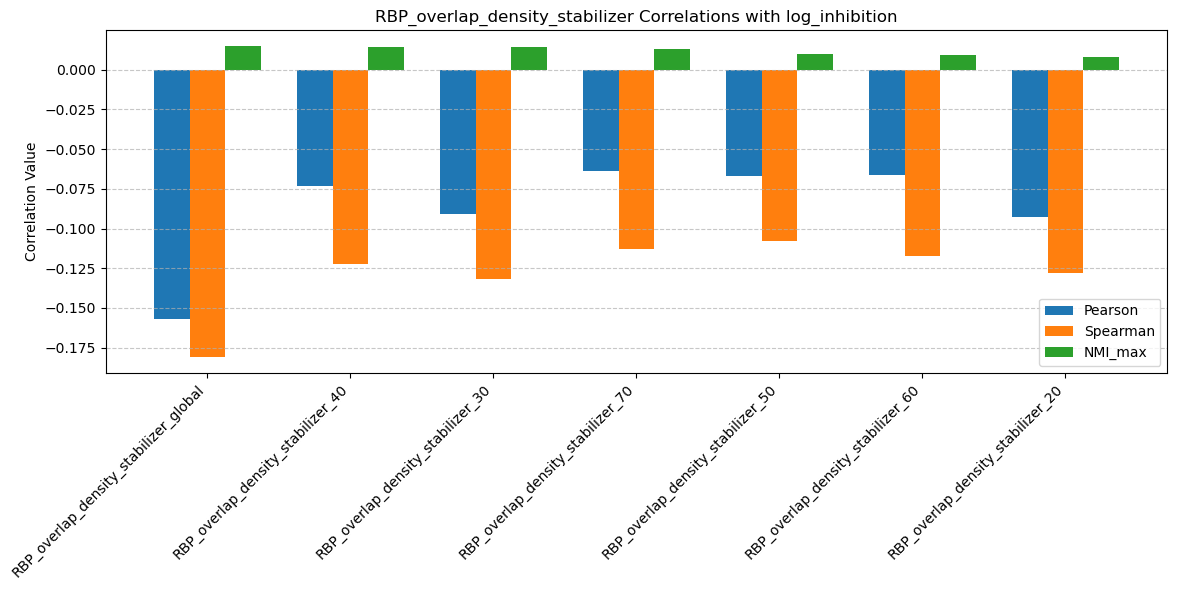

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_density_stabilizer', title='RBP_overlap_density_stabilizer Correlations with log_inhibition')


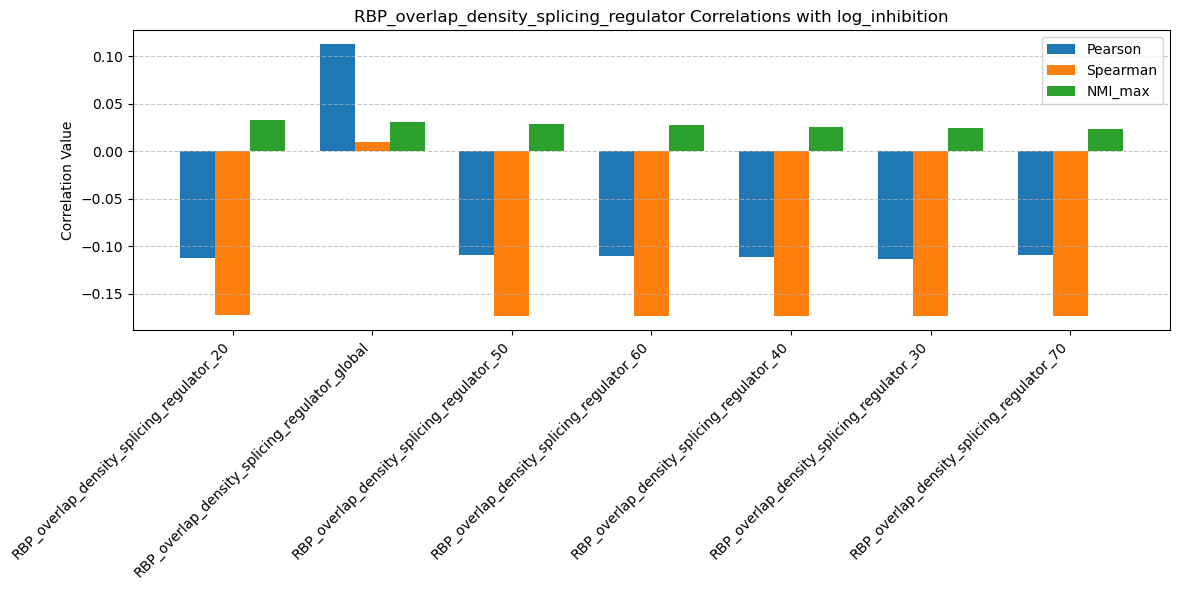

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_density_splicing_regulator', title='RBP_overlap_density_splicing_regulator Correlations with log_inhibition')

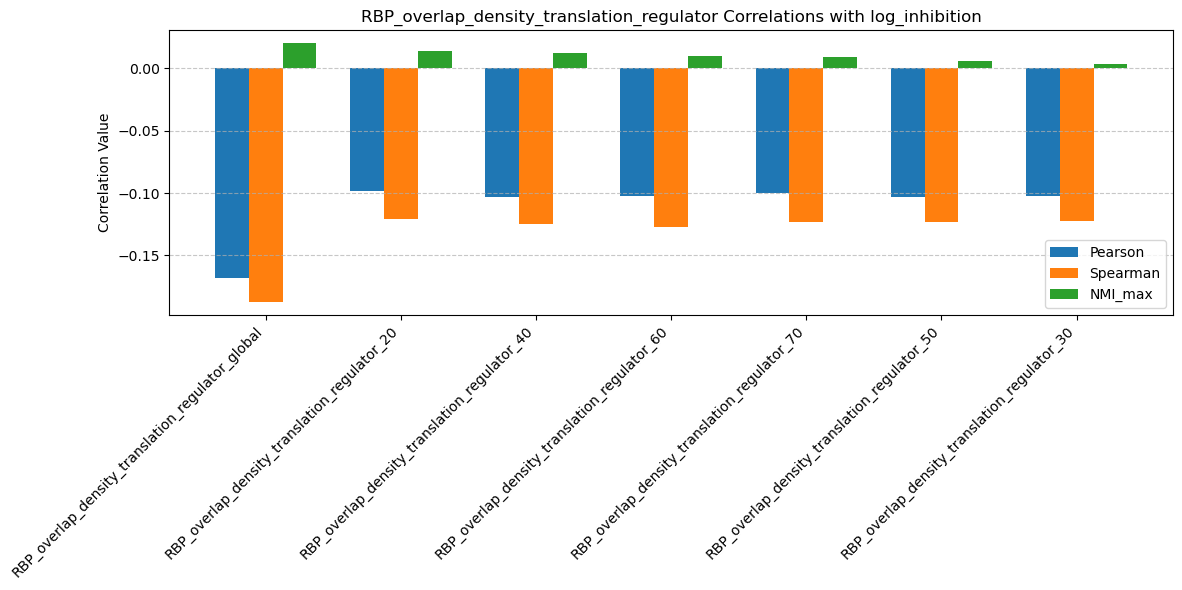

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_density_translation_regulator', title='RBP_overlap_density_translation_regulator Correlations with log_inhibition')


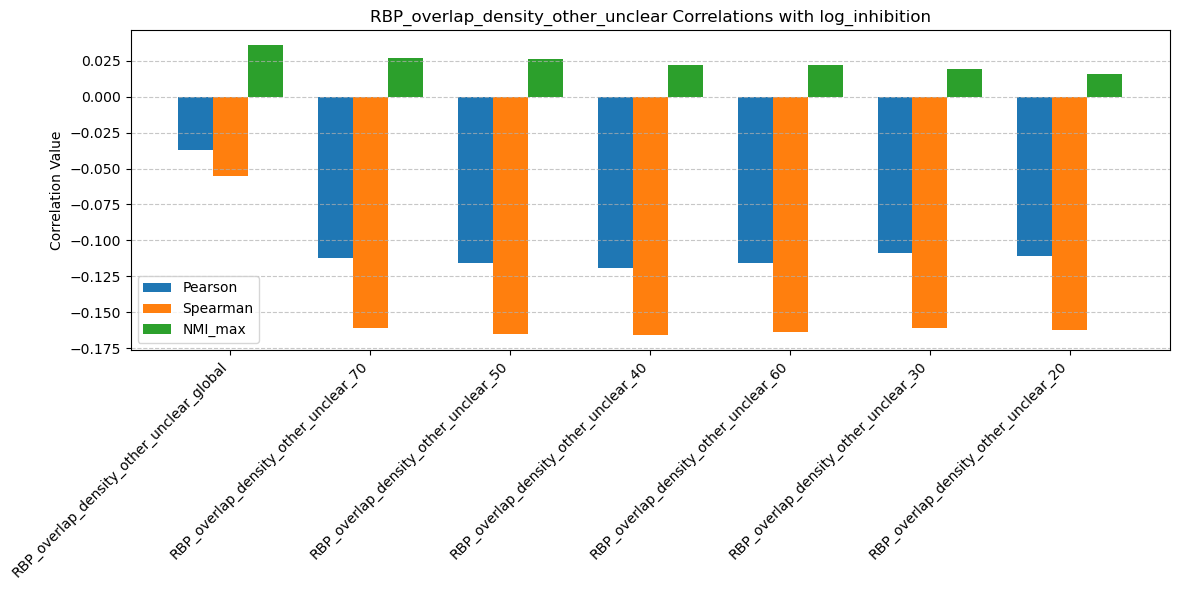

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_density_other_unclear', title='RBP_overlap_density_other_unclear Correlations with log_inhibition')

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_density_m6A', title='RBP_overlap_density_m6A_reader Correlations with log_inhibition')



ratio and delta features

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_delta__destabilizer_vs_stabilizer', title='RBP_overlap_delta__destabilizer_vs_stabilizer Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_ratio__destabilizer_vs_stabilizer', title='RBP_overlap_ratio__destabilizer_vs_stabilizer Correlations with log_inhibition')


In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_delta__destabilizer_vs_splicing_regulator', title='RBP_overlap_delta__destabilizer_vs_splicing_regulator Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_ratio__destabilizer_vs_splicing_regulator', title='RBP_overlap_ratio__destabilizer_vs_splicing_regulator Correlations with log_inhibition')


In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_delta__destabilizer_vs_translation_regulator', title='RBP_overlap_delta__destabilizer_vs_translation_regulator Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_ratio__destabilizer_vs_translation_regulator', title='RBP_overlap_ratio__destabilizer_vs_translation_regulator Correlations with log_inhibition')


In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_delta__splicing_regulator_vs_translation_regulator', title='RBP_overlap_delta__splicing_regulator_vs_translation_regulator Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_ratio__splicing_regulator_vs_translation_regulator', title='RBP_overlap_ratio__splicing_regulator_vs_translation_regulator Correlations with log_inhibition')


In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_delta__other_unclear_vs_stabilizer', title='RBP_overlap_delta__other_unclear_vs_stabilizer Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_ratio__other_unclear_vs_stabilizer', title='RBP_overlap_ratio__other_unclear_vs_stabilizer Correlations with log_inhibition')


In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_delta__other_unclear_vs_destabilizer', title='RBP_overlap_delta__other_unclear_vs_destabilizer Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_ratio__other_unclear_vs_destabilizer', title='RBP_overlap_ratio__other_unclear_vs_destabilizer Correlations with log_inhibition')


In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_delta__m6A_reader_vs_destabilizer', title='RBP_overlap_delta__m6A_reader_vs_destabilizer Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_ratio__m6A_reader_vs_destabilizer', title='RBP_overlap_ratio__m6A_reader_vs_destabilizer Correlations with log_inhibition')


In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_delta__m6A_reader_vs_stabilizer', title='RBP_overlap_delta__m6A_reader_vs_stabilizer Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_ratio__m6A_reader_vs_stabilizer', title='RBP_overlap_ratio__m6A_reader_vs_stabilizer Correlations with log_inhibition')


In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_delta__m6A_reader_vs_translation_regulator', title='RBP_overlap_delta__m6A_reader_vs_translation_regulator Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_ratio__m6A_reader_vs_translation_regulator', title='RBP_overlap_ratio__m6A_reader_vs_translation_regulator Correlations with log_inhibition')


In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_delta__m6A_reader_vs_splicing_regulator', title='RBP_overlap_delta__m6A_reader_vs_splicing_regulator Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_ratio__m6A_reader_vs_splicing_regulator', title='RBP_overlap_ratio__m6A_reader_vs_splicing_regulator Correlations with log_inhibition')


In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_delta__m6A_reader_vs_other/unclear', title='RBP_overlap_delta__m6A_reader_vs_other/unclear Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_ratio__m6A_reader_vs_other/unclear', title='RBP_overlap_ratio__om6A_reader_vs_other/unclear Correlations with log_inhibition')


RBP overlap frac features

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_destabilizer_left_', title='RBP_overlap_frac_destabilizer_left part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_destabilizer_core_', title='RBP_overlap_frac_destabilizer_core part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_destabilizer_right_', title='RBP_overlap_frac_destabilizer_right part of the ASO Correlations with log_inhibition')

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_stabilizer_left_', title='RBP_overlap_frac_stabilizer_left part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_stabilizer_core_', title='RBP_overlap_frac_stabilizer_core part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_stabilizer_right_', title='RBP_overlap_frac_stabilizer_right part of the ASO Correlations with log_inhibition')

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_splicing_regulator_left_', title='RBP_overlap_frac_splicing_regulator_left part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_splicing_regulator_core_', title='RBP_overlap_frac_splicing_regulator_core part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_splicing_regulator_right_', title='RBP_overlap_frac_splicing_regulator_right part of the ASO Correlations with log_inhibition')

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_stranslation_regulator_left_', title='RBP_overlap_frac_translation_regulator_left part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_translation_regulator_core_', title='RBP_overlap_frac_translation_regulator_core part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_translation_regulator_right_', title='RBP_overlap_frac_translation_regulator_right part of the ASO Correlations with log_inhibition')

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_other_unclear_left_', title='RBP_overlap_frac_other_unclear_left part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_other_unclear_core_', title='RBP_overlap_frac_other_unclear_core part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_other_unclear_right_', title='RBP_overlap_frac_other_unclear_right part of the ASO Correlations with log_inhibition')

No features found starting with 'RBP_overlap_frac_other_unclear_left_'


In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_m6A_reader_left_', title='RBP_overlap_frac_m6A_reader_left part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_m6A_reader_core_', title='RBP_overlap_frac_m6A_reader_core part of the ASO Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_overlap_frac_m6A_reader_right_', title='RBP_overlap_frac_m6A_reader_right part of the ASO Correlations with log_inhibition')

Weighted density features

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_expr_weighted_density_destabilizer', title='RBP_expr_weighted_density_destabilizerr Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_expr_weighted_density_stabilizer', title='RBP_expr_weighted_density_stabilizer Correlations with log_inhibition') 
plot_feature_correlations_by_prefix(results_df, prefix='RBP_expr_weighted_density_splicing_regulator', title='RBP_expr_weighted_density_splicing_regulator Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_expr_weighted_density_translation_regulator', title='RBP_expr_weighted_density_translation_regulator Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_expr_weighted_density_other_unclear', title='RBP_expr_weighted_density_other_unclear Correlations with log_inhibition')      
plot_feature_correlations_by_prefix(results_df, prefix='RBP_expr_weighted_density_m6A_reader', title='RBP_expr_weighted_density_m6A_reader Correlations with log_inhibition')    

NameError: name 'plot_feature_correlations_by_prefix' is not defined

Motif diversity features

In [ ]:
plot_feature_correlations_by_prefix(results_df, prefix='RBP_motif_diversity_destabilizer', title='RBP_motif_diversity_destabilizer Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_motif_diversity_stabilizer', title='RBP_motif_diversity_stabilizer Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_motif_diversity_splicing_regulator', title='RBP_motif_diversity_splicing_regulator Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_motif_diversity_translation_regulator', title='RBP_motif_diversity_translation_regulator Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_motif_diversity_other_unclear', title='RBP_motif_diversity_other_unclear Correlations with log_inhibition')
plot_feature_correlations_by_prefix(results_df, prefix='RBP_motif_diversity__m6A_reader', title='RBP_motif_diversity__m6A_reader Correlations with log_inhibition')